## FEMA's Problem

FEMA has a public relations problem. 

In 2007, then senator Barack Obama ripped Federal Emergency Management Agency (FEMA) for its response to Hurricane Katrina (August, 2005), and with reasonable cause: 

“In many cases, resources that were available were not used, whether Amtrak trains that could have taken evacuees to safety before the storm or the U.S. military's 82nd Airborne division, which spent days on standby waiting for orders that never came. Communications were so impossible the Army Corps of Engineers was unable to inform the rest of the government for crucial hours that levees in New Orleans had been breached.” - [Washington Post]("http://www.washingtonpost.com/wp-dyn/content/article/2005/09/10/AR2005091001529_pf.html?noredirect=on") 

“Hundreds of firefighters who volunteered to help rescue victims of Hurricane Katrina have instead been playing cards, taking classes on FEMA's history and lounging at an Atlanta airport hotel for days while they await orders.” - [USAToday]("http://usatoday30.usatoday.com/news/nation/2005-09-07-firefighters-ga-katrina_x.htm")
    
“Officials said New Mexico offered 200 Guard members the day the storm hit, and the troops were packed and ready to move the next day. But no orders were received to move those troops until two days later, Sept. 1, and 400 soldiers finally flew to the hurricane zone on Sept. 2.” - [NYTimes]("https://www.nytimes.com/2005/09/28/us/nationalspecial/when-storm-hit-national-guard-was-deluged-too.html")

Then president George W. Bush would ultimately sign a 51.8 billion dollor relief bill but the damage would overshadow even that astronomical number, estimated north of 150 billion in damage--all because of the miserable level of preparedness.
The Federal Emergency Management Agency received a portion of the criticism it was due, but this was an insight into how bad things can get if left unchecked. Katrina was a worst case scenario and an outlier as far as disasters are concerned.
Disaster Data and Mitigation Planning

#### The Problem

Can we use FEMA's disaster data to:

1. assess FEMA’s mitigation protocols based on money spent over time
2. rate regions (zipcode or county) for mitigation priority
3. predict disasters to assist mitigation efforts and save money

#### The Client

The US government, state governments, home/flood/disaster insurance companies looking to assess risk.  The private sector could benefit greatly from insights derived from the massive amounts of data FEMA has collected and produced.


### Obtaining, Cleaning, and Wrangling

For this project, I took advantage of OpenFEMA data from [FEMA.gov]("https://www.fema.gov/openfema"). OpenFEMA has the self-proclaimed mission to "execute federal open data machine readable policies and standards, and to promote a culture and empower open government within FEMA." Hopefully, this project does them proud.

Within OpenFEMA are numerous APIs that allow me to pull to-date information on disasters (in the case of this project ranging back to the year 2000). These APIs allowed for the procuring of my data to be the least of my worries, and as an added benefit, they allowed for replicability--instead of downloading .csv files, this code can be run by anyone by just hitting "Run All". By simply running urlretrieve (from the urllib.request package) on the appropriate urls, I was able to find each dataset and convert it into a pandas DataFrame. It was then that I was confronted with just the volume of work that had to be done to clean and wrangle everything.

In [ ]:
# Simplicity example. First dataset : Disaster Declarations Summaries (dds)

url = 'https://www.fema.gov/api/open/v1/DisasterDeclarationsSummaries.csv'
file = 'DisasterDeclarationsSummaries.csv'
urlretrieve(url, file)

dds = pd.read_csv(file, sep = ',')

The above code was repeated with two other sets of data: Housing Assistance for Owners and Housing Assistance for Renters. All of the obtaining, cleaning, and wrangling code can of course be found in a separate notebook (FEMA-data-analysis.ipynb)

As mentioned earlier, it was the cleaning and wrangling that proved to be the biggest headache as even FEMA acknowledged on their site, with this much data "there is bound to be some human error." Perhaps one of the bigger understatements...

As a first simple example, zip code data (which is important towards the end of indexing this data) came in multiple data types and initially very confusing:

In [ ]:
df = df.dropna(subset=['zipCode'])
df = df[df['zipCode']!='00000']
df = df[df['zipCode']!=0]

Then came the issue of our data being in multiple types elsewhere. However, once our numerical data was converted appropriately using .astype() where needed, we were able to approach the merging of these DataFrames. Now, the Owners Assistance and Renters Assistance DataFrames had repeated columns that needed to be summed--though not all their columns needed this. The strategy we used was to:
    1. take advantage of .iloc[] and slice the appropriate columns from each, 
    2. create temporary 'sub' DataFrames, 
    3. concatenate them chaining on .sum(), 
    4. then merge back in the other previously unused columns:

In [ ]:
sub_own = own_df.iloc[:,[0,3,4,5,7,9,14,15,16,17,18,19,20,21,22]]
sub_rent = rent_df.iloc[:,[0,1,2,3,4,5,9,10,11,12,13,14,15,16,17]]
total_sub = pd.concat([sub_own,sub_rent]).groupby(['disasterNumber','zipCode','city']).sum().reset_index()

total_sub = total_sub.set_index(['disasterNumber','zipCode','city'])

own_remain = own_df.reset_index().iloc[:,[0,1,2,3,4,6,8,10,11,12,13]].set_index(['disasterNumber','zipCode','city'])
rent_remain = rent_df.reset_index().iloc[:,[0,1,2,6,7,8]].set_index(['disasterNumber','zipCode','city'])

# duplicate records randomly became an issue at this point and this was a broad brushstrokes approach to getting
# around them

total_sub = total_sub[~total_sub.index.duplicated()]
own_remain = own_remain[~own_remain.index.duplicated()]
rent_remain = rent_remain[~rent_remain.index.duplicated()]

#list of the dfs I want to combine, all of which share common indices

df_list = [total_sub.reset_index(),own_remain.reset_index(),rent_remain.reset_index()]
merge_df = df_list[0]
for df_ in df_list[1:]:
    merge_df = merge_df.merge(df_, on=['disasterNumber','zipCode','city'], how = 'outer')

merge_df = merge_df.set_index(['disasterNumber','zipCode','city'])

All that remained after this step was to merge this mega DataFrame with the first data mentioned earlier, the Disaster Declaration Summaries:

In [ ]:
df = pd.merge(merge_df.reset_index(), dds_dup.drop(columns = 'state').reset_index(), on = 'disasterNumber')

# Save this df so we can use it later in different notebooks.

df.to_csv('FEMA.csv',sep = '\t',index = ['disasterNumber','zipCode','city'])

While concatenating and merging all of this data initially felt satisfying (I mean this turned into quite a robust dataset), the human errors proved to really inhibit a lot of my analysis. Misspelling city names created new rows with minimal data and grossly pulled trends toward the side of zero. While this didn't make the DataFrame unuseable, our means of getting around the ugly looking plots it created was to aggregate the information by disaster:

In [ ]:
group_df = df.iloc[:,2:23].groupby('disasterNumber').sum() # variables for which we need a sum aggregate

cat_vars = df.iloc[:,23:36].groupby('disasterNumber').first() # variables for which the data is consistent across records

agg_df = cat_vars.reset_index().merge(group_df.reset_index(), on = 'disasterNumber').set_index('disasterNumber')

This aggregate DataFrame, 'agg_df', ended up being the data for most of my exploratory and inferential analysis.

### Initial findings from exploratory analysis 

In [1]:
import pandas as pd

# After executing the "Wrangling" code for my capstone, the following df will be stored locally as 'FEMA.csv'
file = "FEMA.csv"
dates = ['declarationDate','incidentBeginDate','incidentEndDate','disasterCloseOutDate']
df = pd.read_csv(file, sep = '\t', index_col = ['disasterNumber', 'zipCode', 'city'], parse_dates = dates, low_memory = False)

file = "aggregate_FEMA.csv"
dates = ['declarationDate','incidentBeginDate','incidentEndDate','disasterCloseOutDate']
agg_df = pd.read_csv(file, sep = '\t', index_col = ['disasterNumber'], parse_dates = dates, low_memory = False)

In [19]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (15, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

#### Summary of findings
#### Visuals and statistics to support findings

A bit of wrangling still remains in order to show what was discovered in our EDA. That is conducted below:

In [4]:
dn_list = agg_df.index
zip_counts = []

for dn in dn_list:
    a = df.reset_index().set_index('disasterNumber').loc[dn,:]
    count = len(pd.Series(a.zipCode).unique())
    zip_counts.append(count)

# this is our measure of "spread" for any one disaster--how many zip codes did it cover

agg_df['zip_counts'] = zip_counts

agg_df.to_csv('aggregate_FEMA.csv', sep = '\t')

# important columns for checking correlation

corr_cols = agg_df.reset_index()[['disasterNumber','title','incidentType','fyDeclared','disasterLength','zip_counts',
                                  'totalApprovedIhpAmount','approvedForFemaAssistance']]

# last bit of data wrangling that needs to be done (unescapable)

corr_cols['disasterLength'] = corr_cols['disasterLength'].str.split(expand = True)
corr_cols['disasterLength'] = pd.to_numeric(corr_cols['disasterLength'], errors = 'coerce')

corr_cols = corr_cols.rename(columns = {'disasterLength':'length',
                                        'totalApprovedIhpAmount':'apprAmount',
                                        'approvedForFemaAssistance':'apprIndv'})

corr_cols = corr_cols.set_index('disasterNumber')

corr_cols.sort_values('zip_counts', ascending = False).head()

,title,incidentType,fyDeclared,length,zip_counts,apprAmount,apprIndv
disasterNumber,,,,,,,
4337,HURRICANE IRMA,Hurricane,2017,44.0,1773,1.020335e+09,777198.0
1557,TROPICAL DEPRESSION IVAN,Hurricane,2004,14.0,1147,8.654718e+07,25009.0
1545,HURRICANE FRANCES,Hurricane,2004,34.0,1076,4.097340e+08,226457.0
4339,HURRICANE MARIA,Hurricane,2017,59.0,986,1.244248e+09,464570.0
4020,HURRICANE IRENE,Hurricane,2011,10.0,949,1.028656e+08,22892.0


Now that we have the information loaded and correctly constructed, let's look at some correlations (or in our case, what end up being non-correlations where we might expect correlations).

In [4]:
corr_cols[2:].corr()

,fyDeclared,length,zip_counts,apprAmount,apprIndv
fyDeclared,1.000000,-0.059470,-0.040830,-0.025271,-0.002058
length,-0.059470,1.000000,0.208285,0.119449,0.125618
zip_counts,-0.040830,0.208285,1.000000,0.445605,0.664998
apprAmount,-0.025271,0.119449,0.445605,1.000000,0.828424
apprIndv,-0.002058,0.125618,0.664998,0.828424,1.000000


    Right away, we see that nothing about these disasters is correlated in any way with time (as we should expect), so we can write that off. Interestingly, the length of the disaster also shows weak correlations with things like cost and spread ('apprAmount' and 'zip_counts', respectively). Length here is a function of end date and start date--does this weak correlation correspond with limited initiative on FEMA's part end a disaster as quickly as possible? In essence, because their payout is potentially 'uneffected' by how long it takes a disaster to end, what is FEMA's motivation to reach a conclusion?
    
Ho: shorter disasters and longer disasters cost FEMA the same amount.

Ha: shorter disasters and longer disasters do not cost FEMA the same.

In [5]:
corr_cols['length'].describe()

count    305.000000
mean      21.691803
std       28.121858
min       -1.000000
25%        4.000000
50%       12.000000
75%       29.000000
max      168.000000
Name: length, dtype: float64

In [6]:
median = 12

# median disaster length is 12 days, so we can divide disasters in short and long around 12

short = corr_cols[corr_cols['length'] <= median]
long = corr_cols[corr_cols['length'] > median]

s_count = short.shape[0]
l_count = long.shape[0]

print("Number of short disasters : ", s_count)
print("Number of long disasters : ", l_count)

Number of short disasters :  158
Number of long disasters :  147


In the EDA portion of this capstone, we used a t-test for our hypotheses:

In [7]:
from scipy import stats
T, p = stats.ttest_ind(short['apprAmount'],
                       long['apprAmount'],
                       equal_var = False)

print('Test Statistic (T) : ', T)
print('p-value : ', p)

Test Statistic (T) :  -2.4643699034225706
p-value :  0.014807271382714208


With a p-value of 0.0148, we reject our null hypothesis short and long disasters cost FEMA the same amount. However, it's important to realize that with a lower alpha (e.g. 0.01) we should have failed to reject. With this knowledge, we need further insights--perhaps an industry specific understanding of disaster recovery methods.

Perhaps we chose our division of lengths too arbitrarily. It should be noted that if we designate 'short disasters' as those lasting two weeks or less and 'long disasters' as lasting three weeks or more, the p-value is still only 0.027--still failing to reject the null.

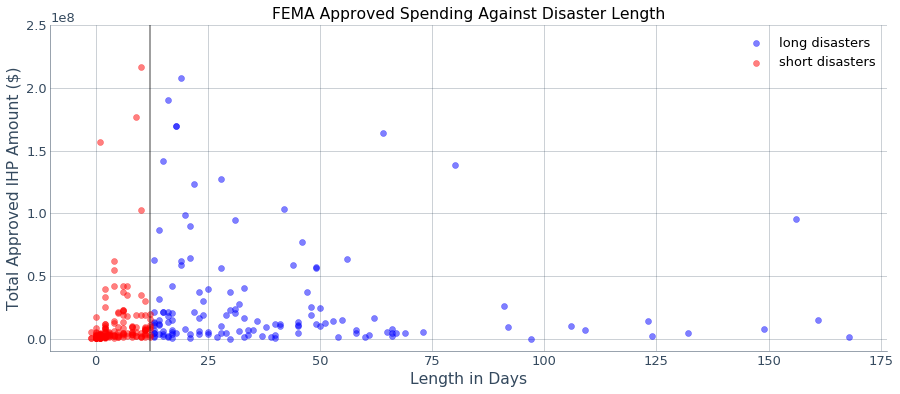

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(long['length'], long['apprAmount'], c='b', label="long disasters", alpha=0.5)

plt.scatter(short['length'], short['apprAmount'], c='r', label="short disasters", alpha=0.5)
plt.axvline(x = median, color = 'k', alpha = 0.5)


#plt.xlim([-100,4000])
plt.ylim([-1e7,2.5e8])
plt.xlabel('Length in Days')
plt.ylabel('Total Approved IHP Amount ($)')
plt.title('FEMA Approved Spending Against Disaster Length')
plt.legend()
plt.show()

Here is a case of statistical significance versus practical significance: yes, we ought to reject our null, but the plot communicates the idea that as disasters stretch out, spending falls dramatically. That, in general, there's a line drawn around 15,000,000 dollars and spending will rarely exceed that. 

As we round out this project, analysis will need to go deeper into how individual zip codes are effected compared to one another. Perhaps there's a clustering analysis we can do to help towards our second objective of parsing out which areas of the country should be budgeted the most.

In [9]:
corr_cols.zip_counts.describe()

count     306.00000
mean      174.77451
std       216.51809
min         1.00000
25%        39.00000
50%        99.50000
75%       225.00000
max      1773.00000
Name: zip_counts, dtype: float64

We can run the same analysis with our measure of spread, zip counts. As the descriptive statistics above show us though, the top end of our data is pulling the mean far to the right, so let's just consider the first 3 quartiles:

In [10]:
# create temporary df just to account for the far right

x = corr_cols[corr_cols.zip_counts <= 225]
x.zip_counts.describe()

count    230.000000
mean      79.656522
std       58.686640
min        1.000000
25%       32.000000
50%       63.000000
75%      123.500000
max      225.000000
Name: zip_counts, dtype: float64

In [11]:
mean = 80

# mean zip count is 80 zip codes, so we can divide disasters into big and small around 170

small = x[x['zip_counts'] <= mean]
big = x[x['zip_counts'] > mean]

s_count = small.shape[0]
b_count = big.shape[0]

print("Number of small disasters : ", s_count)
print("Number of big disasters : ", b_count)

Number of small disasters :  136
Number of big disasters :  94


In [12]:
lim_x = x[x['apprIndv'] < 2000]

a = lim_x['apprIndv']
b = lim_x['apprAmount']

print("Correlation between Total Amount and Total Individuals:",a.corr(b))

Correlation between Total Amount and Total Individuals: 0.7053571861660324


Slope :  4161.37


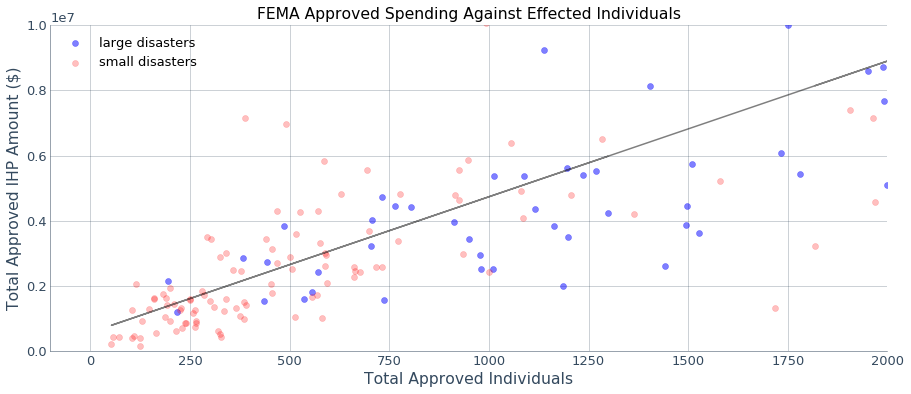

In [21]:
import numpy as np

# Deriving slope,intercept values
slope, intercept = np.polyfit(a, b, 1)
abline_values = [slope * i + intercept for i in a]

print('Slope : ', round(slope, 2))

plt.scatter(big['apprIndv'], big['apprAmount'], c='b', label="large disasters", alpha=0.5)

plt.scatter(small['apprIndv'], small['apprAmount'], c='r', label="small disasters", alpha=0.25)


plt.plot(a, abline_values, 'k', alpha = 0.5)
plt.ylim([-50,10000000])
plt.xlim([-100, 2000])
plt.xlabel('Total Approved Individuals')
plt.ylabel('Total Approved IHP Amount ($)')
plt.title('FEMA Approved Spending Against Effected Individuals')
plt.legend()
plt.show()

The slope would suggest that for every approved-for-assistance individual, FEMA is paying out another 4000+ dollars, irrespective of the size of the disaster.

We can create a new feature based on our fiscal year declared feature to look at how recent a disaster has struck. We'll call that 'age'. When we add this feature and run a correlation test, surprisingly, we actually get a bite. One other feature correlates decently with how long ago the disaster happened--iaProgramDeclared. 'ia' simply stands for Individual Assistance and many of the things this program would do are seemingly detailed out as other distinct features already. But according to FEMA's records, the last time a disaster warranted declaring such a program was 2008 (see plot below).

In [14]:
agg_df['age'] = 2019 - agg_df['fyDeclared']

In [15]:
agg_df.corr().sort_values('age', ascending = False).loc[:,'age'][0:3]

age                  1.000000
iaProgramDeclared    0.617429
rentalAmount         0.060675
Name: age, dtype: float64

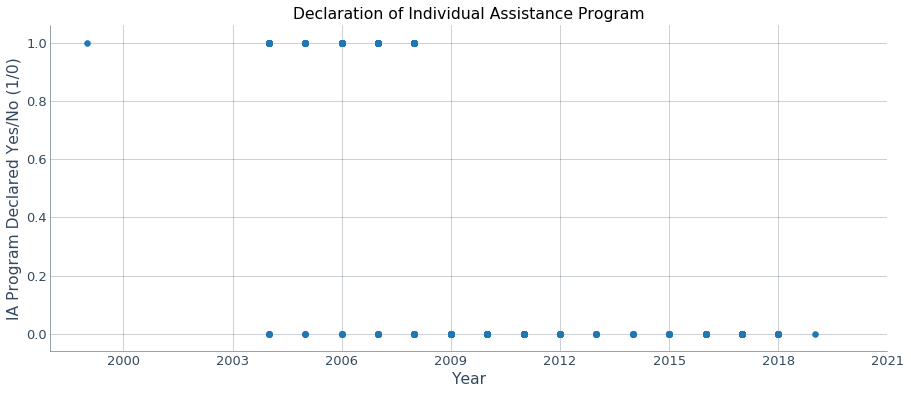

In [22]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy.special import expit

plt.scatter(agg_df['fyDeclared'], agg_df['iaProgramDeclared'])
plt.xlabel('Year')
plt.ylabel('IA Program Declared Yes/No (1/0)')
plt.title('Declaration of Individual Assistance Program')
plt.xticks(ticks = [2000, 2003, 2006, 2009, 2012, 2015, 2018, 2021])

plt.show()